### This notebook primarily serves as an exploratory analysis of our insider trade data set, 
which has all insider trades made in the month of June 2021. We
- load, clean, and format the data from a CSV,
- explore the relationship between insider trade occurrence and ticker price change soon thereafter,
- explore the relationship between volume leading up to a trade and eventual price change, and
- visualize some examples of ticker data with insider trades overlaid.

In [63]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from my_functions import *

pd.options.mode.chained_assignment = None
plt.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
insiderDat, historicDat = cleanAndFormatDF(
    'data/sec4_JuneToAug2021', 
    'data/insiderDat_JuneToAug2021_clean', 
    'data/historicDat', 
    newORload='load', 
    startDate='2021-06-01', 
    endDate='2022-06-01'
)

There are 2875 unique tickers.
14 tickers to download.
[*********************100%***********************]  14 of 14 completed

Example ticker data for CMBM:
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-06-01  58.939999  59.250000  55.770000  57.500000  57.500000   219100
2021-06-02  54.075001  54.619999  48.009998  48.910000  48.910000   754300
2021-06-03  45.680000  46.610001  45.040001  45.619999  45.619999  1881600
2021-06-04  45.400002  48.932999  45.310001  48.150002  48.150002  1331000
2021-06-07  48.000000  50.418999  47.810001  49.689999  49.689999   479100
...               ...        ...        ...        ...        ...      ...
2022-05-24  13.350000  13.375000  12.640000  13.180000  13.180000   111600
2022-05-25  13.130000  13.560000  13.000000  13.340000  13.340000    96000
2022-05-26  13.260000  13.900000  13.140000  13.770000  13.770000   106600
2022-05-27  13.970

In [14]:
print('Here is the top of our cleaned dataframe of trades:\n')
insiderDat.head()

Here is the top of our cleaned dataframe of trades:



,FilingDate,TradeDate,Ticker,CompanyName,InsiderName,Title,TradeType,Price,Qty,Owned,DeltaOwn,Value
0,2021-06-01,2021-05-27,CMBM,Cambium Networks Corp,Rau Sally,GC,S - Sale,58.60,-4938.0,0.0,-100.0,-289353.0
1,2021-06-01,2021-05-27,PANL,Pangaea Logistics Solutions Ltd.,"Pangaea One Acquisition Holdings Xiv, LLC",10%,S - Sale,4.21,-184466.0,6788742.0,-3.0,-775965.0
2,2021-06-01,2021-05-27,TALO,Talos Energy Inc.,"Apollo Management Holdings Gp, LLC",10%,S - Sale,14.10,-81942.0,18808537.0,0.0,-1155620.0
3,2021-06-01,2019-07-18,CLXT,"Calyxt, Inc.",Dumont Philippe,Dir,S - Sale,10.00,-706.0,16354.0,-4.0,-7060.0
4,2021-06-01,2021-05-27,FLUX,"Flux Power Holdings, Inc.",Johnson Michael,"Dir, 10%",S - Sale,10.55,-38738.0,4584558.0,-1.0,-408564.0


In [16]:
'''
Get historic SPY data for benchmarking.
'''
SP500Dat = getHistoricDat(['SPY'], '2021-06-01', '2022-06-01', 'data/SP500Dat')

1 tickers to download.
[*********************100%***********************]  1 of 1 completed


In [17]:
'''
Get price percentage differences after 1 day, 1 week, 1 month, and 3 months.
'''
EODayPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=1, priceTime='Close')
EOWeekPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=7, priceTime='Close')
EOMonthPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=30, priceTime='Close')
EO3MonthPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=90, priceTime='Close')

In [18]:
EO_Prices = {'1day': EODayPrice, '1week': EOWeekPrice, '1month': EOMonthPrice, '3month': EO3MonthPrice}

print('(% change in CMBM price, % change in S&P500) in 3 months:')
EO_Prices['3month']['CMBM0']

(% change in CMBM price, % change in S&P500) in 3 months:


(-35.947822902513586, 7.758476068531511)

### Here we visualize the distribution of changes in price after insider trades.

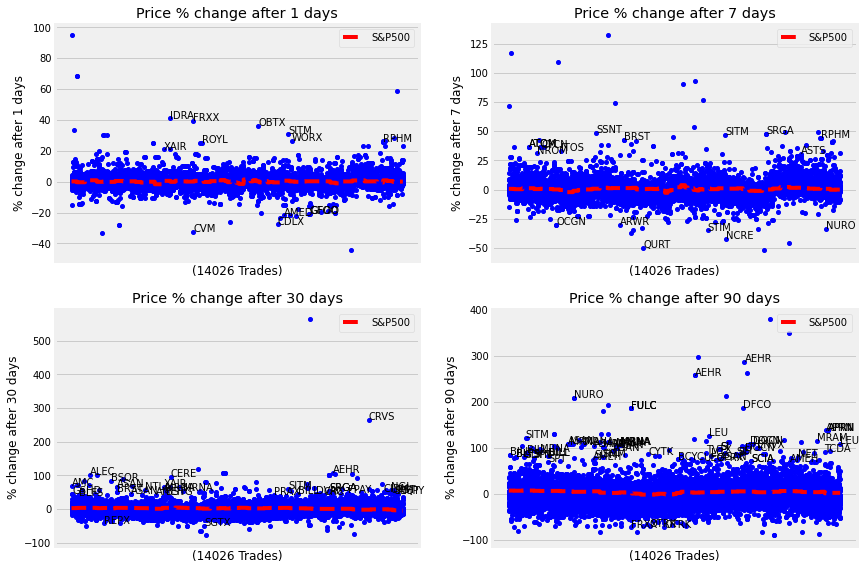

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))

plotPriceDifference(EO_Prices['1day'], delta=1, labelThresh=20, ax=axs[0,0])
plotPriceDifference(EO_Prices['1week'], delta=7, labelThresh=30, ax=axs[0,1])
plotPriceDifference(EO_Prices['1month'], delta=30, labelThresh=40, ax=axs[1,0])
plotPriceDifference(EO_Prices['3month'], delta=90, labelThresh=70, ax=axs[1,1])

plt.show()

#### Notice that there are many outliers above and below the "band" in each plot.

Let's look into the price trends of only those tickers that experienced qualitatively-outlying changes.

In [20]:
'''
In this cell, we gather together the price futures of trades that experienced an outlying price jump 
within a given period after an insider trade. The thresholds are determined by 'increaseThresh'.
'''

daysToLookForward = 90  # plot prices over this many days

# Threshold percentage price jump considering 'outlying' for [1 day, 1 week, 1 month, 3 months]
thresh = {'1day': 20, '1week': 30, '1month': 40, '3month': 70}

outlierClosings = {key: {'pos': np.full((1,daysToLookForward), np.nan),
                         'neg': np.full((1,daysToLookForward), np.nan)}
                   for key in thresh.keys()}

for tradeNum, trade in insiderDat.iterrows():
    tick = trade['Ticker']
    tickDat = historicDat[tick]
    tradeName = tick + str(tradeNum)
    fileDate = str(trade['FilingDate'])

    '''
    If the trade's ticker changes by a sufficient amount, store its daily closing for the next 
    'days2lookForward' days.
    '''   
    for key in thresh.keys():
        priceChange = EO_Prices[key][tradeName][0]
        
        if abs(priceChange) > thresh[key]:
            newRow = np.full((1,daysToLookForward), np.nan)
            startingPrice, _ = returnDataOnDate(tick, tickDat, fileDate, delta=0)
            for d in range(daysToLookForward):
                closingPrice, _ = returnDataOnDate(tick, tickDat, fileDate, delta=d)
                newRow[0,d] = 100*(closingPrice-startingPrice)/startingPrice

            if priceChange > 0:
                outlierClosings[key]['pos'] = np.append(outlierClosings[key]['pos'], newRow, axis=0)
            else:
                outlierClosings[key]['neg'] = np.append(outlierClosings[key]['neg'], newRow, axis=0)

### Here, we focus on price trends for only those tickers that achieve outlying results.

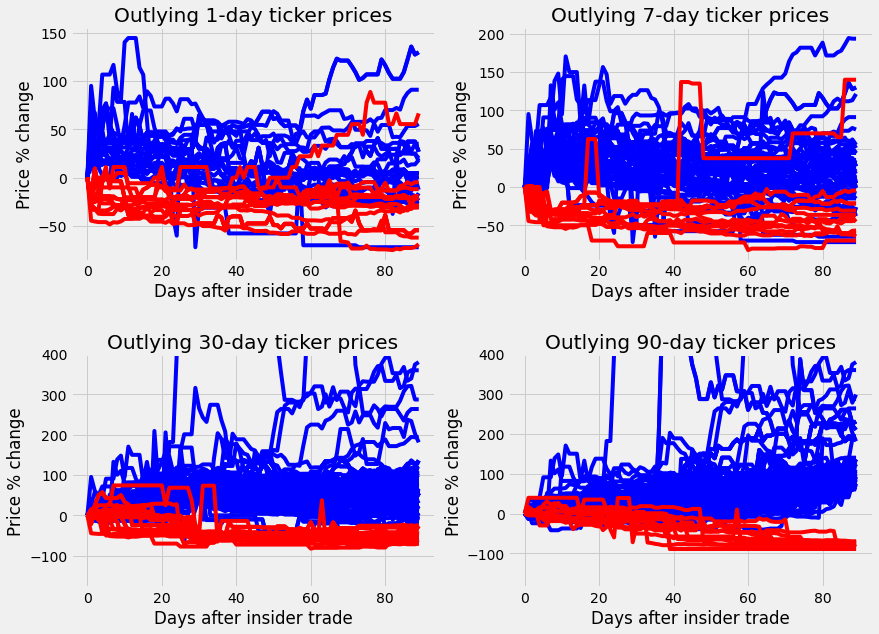

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))

plotOutlyingPriceDifference(outlierClosings['1day'], daysToLookForward, delta=1, ax=axs[0,0])
plotOutlyingPriceDifference(outlierClosings['1week'], daysToLookForward, delta=7, ax=axs[0,1])
plotOutlyingPriceDifference(outlierClosings['1month'], daysToLookForward, delta=30, ax=axs[1,0])
plotOutlyingPriceDifference(outlierClosings['3month'], daysToLookForward, delta=90, ax=axs[1,1])

plt.subplots_adjust(hspace=0.4)
plt.show()

It appears that many outlying upward price jumps occur within at most a few days of the filing date and then fall back down in the next month. However, for prices that **stay** outlying a month or more after the filing, these jumps seem to happen more gradually.

Outlying downward price jumps seem to hold or continue downwards. However, we see a few examples of volatile stocks that significantly gained initially before eventually plummeting!

### Takeaway: 90-day outlying changes seem to be the most monotone. We might train more effectively on them because monotonocity indicates correlation with the trade event.

We want a time window in which to look at price change -- not so small that we fail to account for day-to-day variance, but also not so large that we aren't representing 90-day behavior. 

Let's choose a 10-day average closing.

In [72]:
DAYS_TO_LOOK_FORWARD = 90
DAYS_TO_LOOK_BACK = 6  # for computing volume volatility and related insider buys
WINDOW_LEN = 3

Now we should explore a few other things of interest, namely
- the volume and price volatility over the previous few days, defined by std_dev/mean, and
- plot price with trade types overlaid.

In [73]:
'''
Plot the relationship between max price change in the next 3 months vs most recent change in volume.
'''
startDate = min(insiderDat.FilingDate)
endDate = max(insiderDat.FilingDate)
startDate_str = dt.date.isoformat(startDate)
endDate_str = dt.date.isoformat(endDate)

volatilities = [0]*len(insiderDat.index)
priceChanges = [0]*len(insiderDat.index)
for tradeNum, trade in insiderDat.iterrows():
    tick = trade['Ticker']
    tickDat = historicDat[tick]
    fileDate = trade['FilingDate']
    
    # skip the first DAYS_TO_LOOK_BACK days to ensure there is data to look back at
    if (fileDate - dt.timedelta(days=DAYS_TO_LOOK_BACK)) < startDate:
        volatilities[tradeNum] = (np.nan, np.nan)
        priceChanges[tradeNum] = np.nan
        continue
    
    volatilities[tradeNum] = returnVolatilities(tickDat, 
                                                fileDate, 
                                                'Close',
                                                DAYS_TO_LOOK_BACK)
    
    priceChanges[tradeNum] = returnBestPriceChange(tick, 
                                                   tickDat, 
                                                   fileDate, 
                                                   'Close', 
                                                   WINDOW_LEN, 
                                                   DAYS_TO_LOOK_FORWARD)

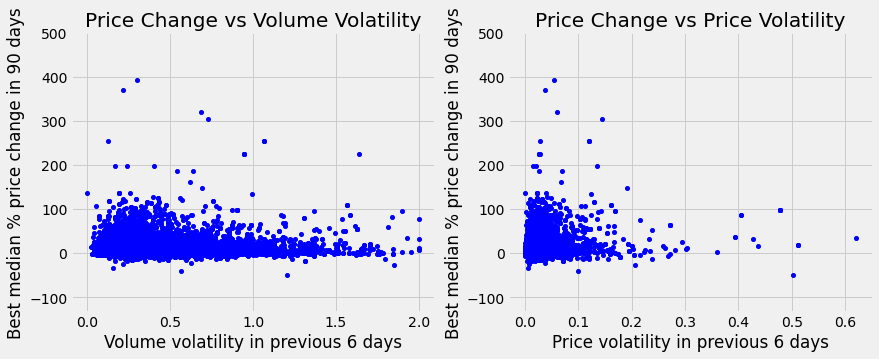

In [74]:
plotVolatilityPriceScatter(volatilities, priceChanges, DAYS_TO_LOOK_FORWARD, DAYS_TO_LOOK_BACK)

I'm kind of surprised by this. I figured that a lot of gainers would have high volatility, but instead it seems to be the opposite.

Actually, now that I think about it, high volatility wouldn't be indicative of sustained price gain after 90 days!



Finally, let's take a closer look at some of the bigger price movements relative to when a trade was made.

In [56]:
insiderDat.Ticker.value_counts()

ZI      187
CONN    114
CRM      92
CVNA     89
META     84
       ... 
COLD      1
CECE      1
CERS      1
CSPI      1
SCSC      1
Name: Ticker, Length: 2564, dtype: int64

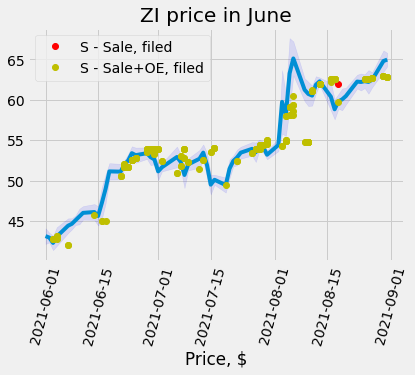

In [58]:
tick = 'ZI'
plotPriceWithTrades(tick, historicDat[tick], insiderDat[insiderDat.Ticker == tick], startDate_str, endDate_str)

ZI has the most trades in the given time period. Insiders seem to be selling as ZI's value climbs.

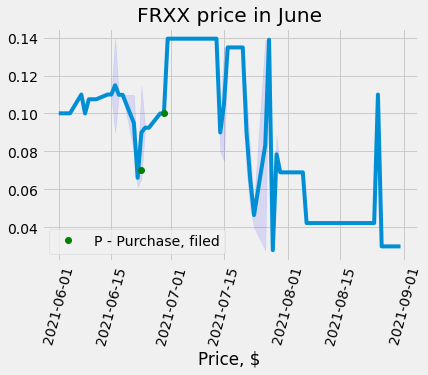

In [59]:
tick = 'FRXX'
plotPriceWithTrades(tick, historicDat[tick], insiderDat[insiderDat.Ticker == tick], startDate_str, endDate_str)

FRXX is an interesting one. The data seems spotty.

The insider(s) made that first purchase the day before and caught that upward price trend, but we wouldn't be able to take advantage with the filing occurring the day after.

However, the second filing occurred just in time to be able to catch the second price jump!

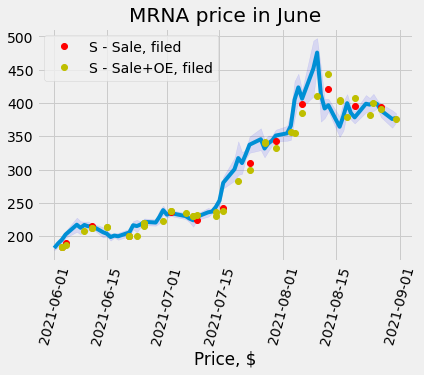

In [60]:
tick = 'MRNA'
plotPriceWithTrades(tick, historicDat[tick], insiderDat[insiderDat.Ticker == tick], startDate_str, endDate_str)

And here's Moderna. We all know their success story in the past couple of years, so something tells me that all of these sales are not very indicative of future price action. That's something worth considering in the modeling process.